# Представление системы мультисемантического моделирования

Выполнил: **Тупицин Станислав Павлович**

## Представление модуля предобработки данных

#### Очистка данных:
    * Удаление неинформативных символов (пунктуации, спецсимволов)
    * Приведение к нижнему регистру
    * Замена аббревиатур на полные формы
    * Удаление символов, не принадлежащих к кириллице

In [1]:
import re

from nltk.corpus import stopwords


def clear_text(text: str) -> str:

    # компрессия символьных шумов
    clean_text: str = re.sub('<[^<]+?>', '', text)
    clean_text = clean_text.lower()
    clean_text = clean_text.replace("i", "и")

    # расшифровка аббревиатур, не нашел подтверждения эффективности данного этапа, поэтому вопрос дискуссионный
    abbreviations: dict = {
        "цмф": "цинтрийские масла феникса",
        "суоч": "система управления операционными чарами",
        "змс": "зачарованная маслостанция",
        "нсс": "назаирская система слива",
        "лдс": "лекарский договор страхования",
        "цист": "цинтрийский стандарт",
        "сокг": "система оплаты карточкой гильдии"}
    for abbr, full_form in abbreviations.items():
        clean_text = clean_text.replace(abbr, full_form)

    # удаление пробелов, переносов, табуляций
    clean_text = re.sub(r'\s+', ' ', clean_text)
    # удаление символов, не принадлежащих кириллице
    clean_text = re.sub(r'[^\u0400-\u04FF\s]', '', clean_text)
    return clean_text


example: str = "«Социальные гарантии, то есть, как и везде, если кто-то умер из своих, естественно, какие-то кроны, свадьба — кроны, так же декретные, это всё. В плане больничного, и в плане ЛДС — нет, такого не было»  «Больничный был, больничный оплачивали, я имею в виду, что полис ЛДС, как в некоторых компаниях, может, в вашей компании ЛДС, такого не было»"  # датасет, id=651
cleared: str = clear_text(example)
cleared

'социальные гарантии то есть как и везде если ктото умер из своих естественно какието кроны свадьба  кроны так же декретные это всё в плане больничного и в плане лекарский договор страхования  нет такого не было больничный был больничный оплачивали я имею в виду что полис лекарский договор страхования как в некоторых компаниях может в вашей компании лекарский договор страхования такого не было'

#### Удаление стоп-слов:
    * Список стоп-слов был взят с сайта https://snipp.ru/seo/stop-ru-words, а также расширен за счет слов, которые встречаются в текстах датасета (например, дон), а также словами, перенимающими старорусский стиль письма(например домъ, въ, нашъ и т.д.)
    
    * Для разделения текста на слова используется библиотека nltk, она также будет использована в дальнейшем в коде библиотеки BERTopic.

In [2]:
from nltk.tokenize import word_tokenize

stopwords_path = "../data/stop-ru.txt"

with open(stopwords_path, "r", encoding="utf-8") as f:
    stopwords: list[str] = [line.strip() for line in f]


def delete_stopwords(text: str) -> str:
    return " ".join([i for i in word_tokenize(text) if i not in stopwords])


without_stopwords: str = delete_stopwords(cleared)
without_stopwords

'социальные гарантии умер какието кроны свадьба кроны декретные плане больничного плане лекарский договор страхования больничный больничный оплачивали имею виду полис лекарский договор страхования компаниях вашей компании лекарский договор страхования'

#### Лемматизация
    * Для лемматизации текста используется библиотека pymorphy3
    * К каждому слову подбирается его начальная форма

In [3]:
# библиотека для русскоязычных nlp проектов
import pymorphy3

morph = pymorphy3.MorphAnalyzer()


def lemmatize(text: str) -> str:
    return " ".join([morph.parse(i)[0].normal_form for i in text.split()])


lemmatized: str = lemmatize(without_stopwords)
lemmatized

'социальный гарантия умереть какиеть крона свадьба крона декретный план больничный план лекарский договор страхование больничный больничный оплачивать иметь вид полис лекарский договор страхование компания ваш компания лекарский договор страхование'

#### Фильтрация частей речи
    * Фильтрация частей речи реализуется предобученной моделью из ряда spacy
    * Релевантными частями речи считаются существительные, прилагательные, глаголы и наречия

In [4]:
from spacy.util import load_model_from_path
from pathlib import Path
import warnings

# spacy ругается на зависимости, связанные за работу в блокнотах :)
warnings.filterwarnings("ignore", category=UserWarning, module='spacy.util')

tagged_model_path: Path = Path("../data/ru_core_news_sm-3.1.0/ru_core_news_sm/ru_core_news_sm-3.1.0")

nlp = load_model_from_path(tagged_model_path)

In [5]:
def keep_only(text: str, parts: list[str]) -> str:
    doc = nlp(text)
    return " ".join([token.text for token in doc if token.pos_ in parts])

kept: str = keep_only(lemmatized, ["NOUN", "ADJ", "VERB", "ADV"])
kept

'социальный гарантия умереть какиеть крона крона декретный план больничный план лекарский договор страхование больничный больничный оплачивать иметь вид полис лекарский договор страхование компания компания лекарский договор страхование'

#### Итоги предобработки

Исходный текст


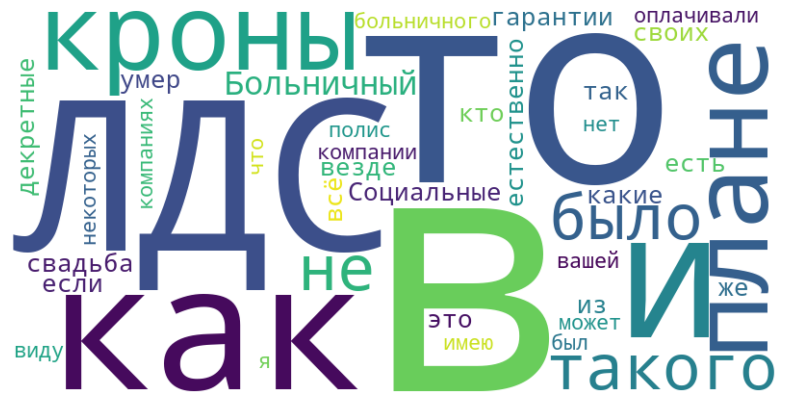

Очищенный текст


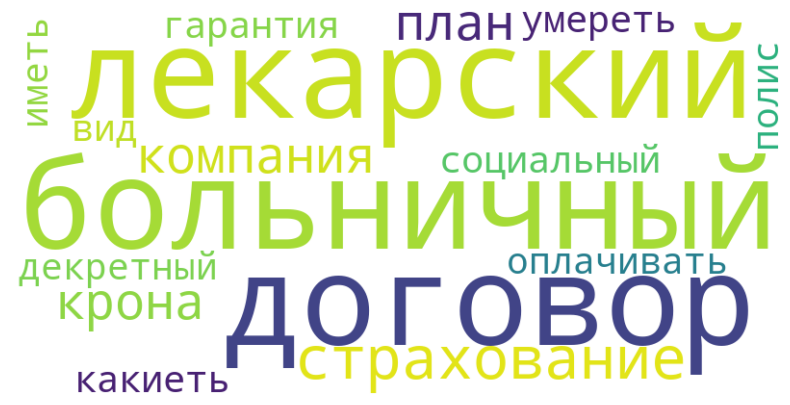

In [6]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt


def generate_word_cloud(text: str):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()


print("Исходный текст")
generate_word_cloud(example)
plt.show()
print("Очищенный текст")
generate_word_cloud(kept)
plt.show()

#### Медианное значение сжатия текста

In [7]:
from src.preprocessing import *
from statistics import median

from plotly import graph_objects as go

import json

from plotly.offline import init_notebook_mode

init_notebook_mode(connected=True)

path: str = "../data/cintra_phoenix_oils_hr_mgck_feather.json"

data: dict = json.load(open(path, encoding="utf-8"))

docs: list[str] = [doc["quote"] for doc in data]
orig_median_length: int = median([len(doc) for doc in docs])

edited: list[str] = preprocess(docs)["Edited"]
edited_median_length = median([len(doc) for doc in edited])

max_length: int = max(orig_median_length, edited_median_length)
min_length: int = min(orig_median_length, edited_median_length)

fig = go.Figure(data=[
    go.Bar(name='Изначальная длина текста', x=['Изначальная длина текста'], y=[max_length]),
    go.Bar(name='Длина обработанного текста', x=['Длина обработанного текста'], y=[min_length])
])
fig.update_layout(
    title='Сравнение длин текстов',
    xaxis_title='Тексты',
    yaxis_title='Длина строк',
    yaxis=dict(range=[min_length - int(min_length * 0.1), max_length + int(max_length * 0.1)]),
    barmode='group'
)
fig.show(renderer="colab")

## Представление модуля тематического моделирования

### Подготовка текстовых данных

Текстовые данные для извлечения тематик подготавливаются модулем "preprocessing"

In [15]:
from src.topic_engine import *
from tqdm import TqdmWarning
import warnings

warnings.filterwarnings("ignore", category=TqdmWarning)

tengine = Tengine(docs, edited)

In [9]:
# Стандартная конфигурация
from sentence_transformers import SentenceTransformer

BERTOPIC_CONFIG = {
    "embedding_model": SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2"),
    "n_gram_range": (1, 3),
    "min_topic_size": 5,
    "top_n_words": 5
}

### Обучение модели

In [16]:
topics, probs = tengine.fit_transform()
# в BERTopic fit_transform возвращает тематики и вероятности присвоения тематики каждому из документов
print(f"Средняя вероятность кластеризации: {probs.mean()}")

Средняя вероятность кластеризации: 0.9700532182699197


### Визуализация тематик

In [17]:
fig = tengine.model.visualize_topics()
fig.show(renderer="colab")

In [18]:
fig = tengine.model.visualize_documents(edited)
fig.show(renderer="colab")

In [19]:
fig = tengine.model.visualize_barchart()
fig.show(renderer="colab")

In [20]:
fig = tengine.model.visualize_heatmap()
fig.show(renderer="colab")

In [21]:
fig = tengine.model.visualize_hierarchy()
fig.show(renderer="colab")

### Уменьшение количества выбросов

In [22]:
from src.preprocessing import *
import json

path: str = "../data/cintra_phoenix_oils_hr_mgck_feather.json"

data: dict = json.load(open(path, encoding="utf-8"))

docs: list[str] = [doc["quote"] for doc in data]
edited = preprocess(docs)["Edited"]
edited.head()

0    ннас ночь райоон час упасть пол вода сттеклять...
1    программа повышение квалификация цинтрийский ф...
2    цинтрийский феникс зачаровать маслостанция пре...
3    полгода ждать установка фильтр маслобаза думат...
4    всьё бумажка летать теряться приходиться зелен...
Name: Edited, dtype: object

In [23]:
print(f"Доля выбросов: {len([i for i in topics if i == -1]) / len(topics)}")
# выбросы в модели помечаются меткой -1

Доля выбросов: 0.0020855057351407717


In [24]:
# reduce_outliers - немного модифицированная для простоты интерфейса реализация BERTopic
tengine.reduce_outliers()
topics: list[int] = tengine.get_topics()
print(f"Доля выбросов: {len([i for i in topics if i == -1]) / len(topics)}")

Доля выбросов: 0.0


### Сохранение модели и тематик

In [25]:
tengine.save_model("../models")
# Tengine.save_topics позволяет сохранять тематики в виде строк в
# json формате для дальнейшей подачи их в качестве аргумента seed_topic_list
tengine.save_topics("../models/topics")

2024-11-14 21:01:22,950 - BERTopic - WARNING: When you use `pickle` to save/load a BERTopic model,please make sure that the environments in which you saveand load the model are **exactly** the same. The version of BERTopic,its dependencies, and python need to remain the same.


### Подгрузка моделей и тематик

Для подгрузки модели и тематик используется встроенная в BERTopic реализация

In [26]:
from src.topic_engine import Tengine

"""
seed_topic_list - аргумент, позволяющий задать возможные для кластеризации тематики в форме строк
seed_topic_list: list[list[str]]
"""
def load_topics(path: str) -> list[list[str]]:
    try:
        with open(path, 'r', encoding='utf-8') as f:
            topics = json.load(f)
            return topics
    except FileNotFoundError:
        raise FileNotFoundError(f"Topics file not found at {path}")


tengine = Tengine(docs, edited, seed_topic_list=load_topics("../models/topics/good_one.json"))

tengine.load_model("../models/good_one.pkl")

topics, probs = tengine.fit_transform()
tengine.model.visualize_documents(edited).show(renderer="colab")

## Эмоциональный анализ текста

In [27]:
import json
import pandas as pd

path: str = "../data/cintra_phoenix_oils_hr_mgck_feather.json"

data: dict = json.load(open(path, encoding="utf-8"))

docs = pd.DataFrame({"Quote": [doc["quote"] for doc in data]})
docs.head()

,Quote
0,«У ннас среди ночi в райооне 55 часов упала по...
1,Программы повышения квалификации через гильдию...
2,"""Мурр... Новиград - город контрастов, да. Но в..."
3,"Типа, вот уже полгода, как мы ждем установки э..."
4,"""Теперь всьё так просто! Раньше бумажки летали..."


### Предобработка для эмоционального анализа
   Пайплайн для предобработки текста для эмоционального анализа выбран следующий:
   * Очистка
   * Удаление стоп-слов
   * Лемматизация
   
   Подобная схема предобработки вдохновлена работой о эмоциональном анализе от [СПбГУ](https://dspace.spbu.ru/bitstream/11701/25732/1/diplom.pdf).

In [28]:
from src.preprocessing import *

sentiment_text: list[str] = \
    preprocess(docs["Quote"], clean_flag=True, delete_stop_words_flag=True, lemmatize_flag=True, keep_only_list=[])[
        "Edited"].to_list()
sentiment_text[:5]

['ннас ночь райоон час упасть пол вода сттеклять тара тобыть лужа сстеккнуть всёё поод ээтый перрвыя падать неправилььный рассчитывать выставлять определённый картинка пара чтоо грохаться полка буттылка',
 'программа повышение квалификация гильдия цинтрийский феникс хитрый хитрый повышаться предпочтение направление гильдия гильдия толкать сотрудник белый змея программа гибкий сотрудник выбирать',
 'мурра новиград контраст цинтрийский феникс зачаровать маслостанция превратиться кот протянуть лапка товарищ помочь груз напряжение спешка мурра работать втроём порознь',
 'полгода ждать установка фильтр маслобаза думать бесконечный огненный огонь затягивать поставка порядок',
 'всьё бумажка летать теряться приходиться зеленос плантир инфрмция руа ничо пропалюта гораздо удобный']

### Объект Sengine

Конструкция Sengine позволяет проводить эмоциональный анализ текста, используя инициализированную модель.

In [29]:
from src.sentiment_engine import Sengine

sengine = Sengine()

Стандартная модель для анализа - [seara/rubert-tiny2-russian-sentiment](https://huggingface.co/seara/rubert-tiny2-russian-sentiment)

In [30]:
docs["Sentiment"] = [sengine.predict(text) for text in sentiment_text]
docs.head()

,Quote,Sentiment
0,«У ннас среди ночi в райооне 55 часов упала по...,negative
1,Программы повышения квалификации через гильдию...,neutral
2,"""Мурр... Новиград - город контрастов, да. Но в...",neutral
3,"Типа, вот уже полгода, как мы ждем установки э...",neutral
4,"""Теперь всьё так просто! Раньше бумажки летали...",neutral


In [31]:
import plotly.express as px
import pandas as pd

sentiment_counts = docs['Sentiment'].value_counts().reset_index()
sentiment_counts.columns = ['Sentiment', 'Count']

fig = px.pie(sentiment_counts, names='Sentiment', values='Count', title='Распределение результатов')
fig.show(renderer="colab")

## Пример компановки модулей

Данные реализации компановки модулей взяты из router.py

In [32]:
import json

path: str = "../data/cintra_phoenix_oils_hr_mgck_feather.json"

data: dict = json.load(open(path, encoding="utf-8"))

docs: list[str] = [doc["quote"] for doc in data]
edited = preprocess(docs)["Edited"]
edited.head()

0    ннас ночь райоон час упасть пол вода сттеклять...
1    программа повышение квалификация цинтрийский ф...
2    цинтрийский феникс зачаровать маслостанция пре...
3    полгода ждать установка фильтр маслобаза думат...
4    всьё бумажка летать теряться приходиться зелен...
Name: Edited, dtype: object

**modelling_pipeline** - функция, объединяющая в себе все модули, реализованные выше, при модернизации системы путем добавления новых методов классификации возможно указать их (методы) в теле функции

In [34]:
from src.router import *
import time

start = time.time()

result = modelling_pipeline(docs, preprocessing_flag=True)
"""
preprocessing_flag - флаг, указывающий на необходимость предобработки текста
также в теле реализации используются предобученные для задач модели, однако возможно использовать сторонние
"""

end = time.time()

print(f"Время работы на обработку {result.shape[0]} документов: {end - start} секунд")
print(f"Время обработки одного документа: {(end - start) / result.shape[0]} секунд")

result

Processing Topic...
Processing Sentiment...
Время работы на обработку 959 документов: 47.02218437194824 секунд
Время обработки одного документа: 0.04903251759327241 секунд


,Doc,Topic,Sentiment
0,«У ннас среди ночi в райооне 55 часов упала по...,"[маслостанция, зачаровать, зачаровать маслоста...",negative
1,Программы повышения квалификации через гильдию...,"[феникс, цинтрийский, цинтрийский феникс, масл...",neutral
2,"""Мурр... Новиград - город контрастов, да. Но в...","[феникс, цинтрийский, цинтрийский феникс, масл...",neutral
3,"Типа, вот уже полгода, как мы ждем установки э...","[маслостанция, зачаровать, зачаровать маслоста...",neutral
4,"""Теперь всьё так просто! Раньше бумажки летали...","[маслостанция, зачаровать, зачаровать маслоста...",neutral
...,...,...,...
954,"«ВВ го Rhode, я не знаю,, у них нет тут ночн...","[маслостанция, зачаровать, зачаровать маслоста...",neutral
955,"Праздники у нас как-то так, ну, были и были, н...","[маслостанция, зачаровать, зачаровать маслоста...",positive
956,“В жеенском кооолектииивъ всё раавно скллокк ...,"[маслостанция, зачаровать, зачаровать маслоста...",neutral
957,"Потом ещё нехватa у нас очень большая, у нас с...","[смена, зачаровать, говорить, работать, маслос...",neutral


Результатами тематического моделирования в данном случае предстает репрезентация документов в виде тематик.

Результатами эмоционального анализа является классификация на позитивные, нейтральные и негативные документы.

In [35]:
result["Topic"] = result["Topic"].apply(lambda x: tuple(x))

In [36]:
import plotly.graph_objects as go
import pandas as pd

# кодирование уникальных значений тематик

topic_encoder = {topic: i for i, topic in enumerate(result['Topic'].unique())}

result['Topic'] = result['Topic'].map(topic_encoder)

topic_sentiment_counts = result.groupby(['Topic', 'Sentiment']).size().reset_index(name='Count')

pivot_table = topic_sentiment_counts.pivot(index='Sentiment', columns='Topic', values='Count').fillna(0)

fig = go.Figure(data=[go.Surface(z=pivot_table.values, x=pivot_table.columns, y=pivot_table.index)])

fig.update_layout(
    title='Распределение тематик и эмоц. оценок на тестовом датасете',
    scene=dict(
        xaxis_title='Topic',
        yaxis_title='Sentiment',
        zaxis_title='Count'
    )
)

fig.show(renderer="colab")

## Итоги работы

## Схема работы реализованной системы

![img](https://sun9-55.userapi.com/impg/tbNKetByORozbM5uzcPZ7hQ8k9QQTltSjDs9_g/9t3yrqaz-58.jpg?size=511x371&quality=96&sign=b8c973ceca77472f203465b670fee279&type=album)

### Использованный стек:


    Python - 3.10.14

    numpy=1.26.4
    pandas=2.2.2
    bertopic=0.16.4
    sentence-transformers=3.2.1
    nltk=3.9.1
    pymorphy3=2.0.2
    spacy=3.7.6
    transformers=4.46.2
    setuptools=75.4.0
    plotly=5.24.1
    tqdm=4.67.0


### Плюсы итоговой реализации

    1. Использование популярных решений - каждая зависимость имеет развитое коммьюнити и обширную документацию
    2. Адаптивная модульная система - возможность калибровки системы, если такая требуется
    3. Гибкость моделей - система может быть использована для работы с любыми текстами при настройке конфигураций используемых моделей
    4. Автономность - система работает автономно и не имеет внешних зависимостей

### Недостатки реализации

    1. Высокоуровневость - при разработке системы используются высокоуровневые фреймворки, что создает как излишнюю громоздкость, так и пространство для оптимизации
    2. Отсутствие асинхронного интерфейса - при разработке проекта планировалось создание асинхронного аналога, однако из-за нехватки ресурсов, времени в частности, от данной идеи пришлось отказаться
    3. Устаревшие версии некоторых зависимостей - из-за отсуствия обновлений в русском nlp тулките, некоторые из зависимостей имеют неактуальные версии, а также используется неактуальная версия ЯП (python 3.10)

### Возможности для роста

    1. Избавление от высокоуровневых зависимостей - использование низкоуровневых (относительно используемых) фреймворков для увеличения скорости работы и занимаемого объема в угоду гибкости системы (приоритет дизайна)
    2. Возможные исследования о приемлимости используемого предпроцессинга - необходимо произвести различные исследования о проводимом предпроцессинге, что не было сделано из-за нехватки времени, использовались результаты исследования СПбГУ, НГУ
    3. Создание асинхронного интерфейса - подобный интерфейс мог бы использоваться для интегрирования в проекты с данной архитектурой

### Численные характеристики системы

    1. Занимаемый объем: 370 МБ без учета установленных зависимостей
    2. Точность кластеризации при тематическом моделировании - 0.68-0.99 в зависимости от данных документов при стандартной конфигурации
    3. Скорость работы на AMD Ryzen 5 5600H 3.30 GHz, 16 GB RAM - 0.049 с. в среднем на строку данного датасета